# Create the mask of ocean region

There are 3 ocean region masks originated from different sources in this document.

In [1]:
import numpy as np
import xarray as xr

In [2]:
vgrid = xr.open_dataset('data/ocean_static_0p25_vgrid.nc').load()
ds_out = xr.Dataset({'lat': vgrid.lat, 'lon':vgrid.lon})

In [3]:
def func_regrid(ds, ds_out, gr_method = 'bilinear', reuse = False):
    import xesmf as xe
    dsr = xe.Regridder(ds, ds_out, gr_method, periodic = True, reuse_weights = reuse, ignore_degenerate = True)
    dsr._grid_in = None
    dsr._grid_out = None
    dsr_out = dsr(ds)
    return dsr_out

In [4]:
################## 1 ##################
### ocean mask grid from https://pop-tools.readthedocs.io/en/latest/examples/region-mask.html
### 2 resolution (fine ~0.1 degree, coarse ~1 degree)
### fine resolution mask is hard to be handle (too large to be regirded)
### the masks are modified following the codes from
### https://github.com/NCAR/pop-tools/blob/9563759ab063ae51356af18eab6cabe901e907bc/pop_tools/grid.py#L107

import os, sys
import os.path
from os import path

def get_mask(n):
    '''
    Input
    ----
    n: resolution scale
        f - fine (~ 0.1 degree)
        c - coarse (~ 1 degree)
    '''
    
    if n == 'c':
        gridf = 'data/horiz_grid_20010402.ieeer8'
        gridl = 'inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8'
        regif = 'data/region_mask_20151008.ieeei4'
        regil = 'inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4'
        lateral_dims = [384, 320]
    elif n == 'f':
        gridf = 'data/horiz_grid_200709.ieeer8'
        gridl = 'inputdata/ocn/pop/tx0.1v2/grid/horiz_grid_200709.ieeer8'
        regif = 'data/region_mask_20080702.ieeei4'
        regil = 'inputdata/ocn/pop/tx0.1v2/grid/region_mask_20080702.ieeei4'
        lateral_dims = [2400, 3600]
    else:
        raise ValueError("Input must be c or f")        
    
    # could no be run on a highmem node (no wget on highmem node)
    if not path.exists(gridf):
        os.system('wget -O {} --no-check-certificate https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/{}'.format(gridf, gridl))
    if not path.exists(regif):
        os.system('wget -O {} --no-check-certificate https://svn-ccsm-inputdata.cgd.ucar.edu/trunk/{}'.format(regif, regil))
    
    nlat = lateral_dims[0]
    nlon = lateral_dims[1]
    
    grid = np.fromfile(gridf, dtype='>f8', count=-1)
    grid = grid.reshape((7, nlat, nlon))
    ULAT = grid[0, :, :].astype(float)
    ULONG = grid[1, :, :].astype(float)
    
    REGION_MASK = np.fromfile(regif, dtype='>i4', count=-1)
    REGION_MASK = REGION_MASK.reshape(lateral_dims).astype(np.int32)
    mask = xr.Dataset()
    mask['ULAT'] = xr.DataArray(np.rad2deg(ULAT), dims=('nlat', 'nlon'),
                                attrs={'units': 'degrees_north', 'long_name': 'U-grid latitude'},
                               )
    
    
    mask['ULONG'] = xr.DataArray(np.rad2deg(ULONG), dims=('nlat', 'nlon'),
                                 attrs={'units': 'degrees_east', 'long_name': 'U-grid longitude'},
                                )
    
    mask['REGION_MASK'] = xr.DataArray(REGION_MASK, dims=('nlat', 'nlon'),
                                       attrs={
                                           'long_name': 'basin index number (signed integers)',
                                           'coordinates': 'ULONG ULAT',
                                       },
                                      )
    
    mask.to_netcdf('data/OceanMask.nc')

get_mask('c') 

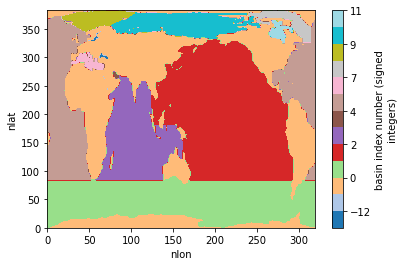

In [5]:
ocean_mask1 = xr.open_dataset('data/OceanMask.nc')
ocean_mask1.REGION_MASK.plot.contourf(levels = np.array(np.unique(ocean_mask1.REGION_MASK)), cmap = 'tab20')
###########################
## 1  Southern Ocean
## 2  Pacific Ocean
## 6  Atlantic Ocean + 8 + 11
## 10 Arctic Ocean

#     Caspian Sea: -14
#     Black Sea: -13
#     Baltic Sea: -12
#     Red Sea: -5
#     Southern Ocean: 1
#     Pacific Ocean: 2
#     Indian Ocean: 3
#     Persian Gulf: 4
#     Atlantic Ocean: 6
#     Mediterranean Sea: 7
#     Lab. Sea & Baffin Bay: 8
#     GIN Seas: 9
#     Arctic Ocean: 10
#     Hudson Bay: 11

/data/shared/marinov/.envs/pangeo/lib/python3.8/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/data/shared/marinov/.envs/pangeo/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


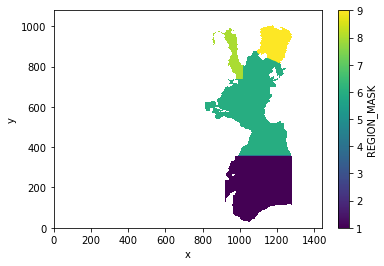

In [8]:
# Atlantic Ocean Mask
mask_a = ocean_mask1.where(ocean_mask1.REGION_MASK.isin([6, 8]))
mask_b = ocean_mask1.where(ocean_mask1.REGION_MASK.isin([1]))
mask_b = xr.merge([mask_b.REGION_MASK.where(mask_b.ULONG < 20), mask_b.REGION_MASK.where(mask_b.ULONG >= 290)], compat="no_conflicts")
mask_c = ocean_mask1.where(ocean_mask1.REGION_MASK.isin([9]))
mask1 = xr.merge([mask_a, mask_b, mask_c], compat="no_conflicts")
mask1 = mask1.rename({'ULONG': 'lon', 'ULAT': 'lat'})
mask1 = func_regrid(mask1.REGION_MASK, ds_out)
mask1.plot()

In [10]:
################## 2 ##################
### ocean mask grid from https://reccap2-ocean.github.io/regions/
### the resolution is 1 degree
### use the biomes of Fay and McKinley to divide the basins into subregions

if not path.exists('data/region_masks.nc'):
    os.system('wget -O data/region_masks.nc --no-check-certificate https://github.com/RECCAP2-ocean/RECCAP2-shared-resources/raw/master/data/regions/RECCAP2_region_masks_all_v20210412.nc')

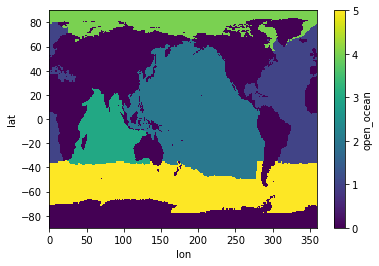

In [13]:
ocean_mask2 = xr.open_dataset('data/region_masks.nc')
ocean_mask2.open_ocean.plot()

/data/shared/marinov/.envs/pangeo/lib/python3.8/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/data/shared/marinov/.envs/pangeo/lib/python3.8/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


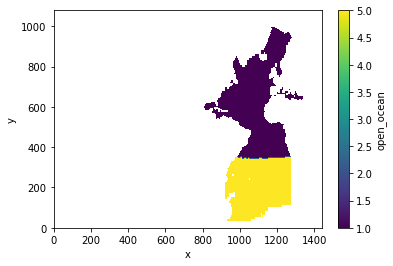

In [14]:
# Atlantic Ocean Mask

mask_a = ocean_mask2.where(ocean_mask2.open_ocean.isin([1]))
mask_b = ocean_mask2.where(ocean_mask2.open_ocean.isin([5]))
mask_b = mask_b.where((mask_b.lon<20) | (mask_b.lon>290))
mask2 = xr.merge([mask_a, mask_b], compat="no_conflicts")

mask2 = func_regrid(mask2.open_ocean, ds_out)
mask2.plot()

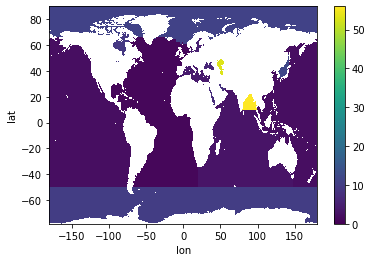

In [20]:
################## 3 ##################
### ocean mask grid from world ocean atlas 18 basins mask (WOA18)
### two resolutions : 0.25 degree & 1 degree


def get_mask_from_list(n):
    '''
    Input
    ----
    n: resolution scale
        f - fine (~ 0.1 degree)
        c - coarse (~ 1 degree)
    '''
    import pandas as pd
    
    if n == 'c':
        mskf = 'data/basinmask_01.msk'
        mskl = 'https://www.ncei.noaa.gov/data/oceans/woa/WOA18/MASKS/basinmask_01.msk'
    elif n == 'f':
        mskf = 'data/basinmask_04.msk'
        mskl = 'https://www.ncei.noaa.gov/data/oceans/woa/WOA18/MASKS/basinmask_04.msk'
    else:
        raise ValueError("Input must be c or f")        
    
    # could no be run on a highmem node (no wget on highmem node)
    if not path.exists(mskf):
        os.system('wget -O {} --no-check-certificate {}'.format(mskf, mskl))  
    
    msk = pd.read_csv(mskf, skiprows=1)

    lat_vals, lat_idx = np.unique(msk.Latitude.values, return_inverse=True)
    lon_vals, lon_idx = np.unique(msk.Longitude.values, return_inverse=True)
    vals_array = np.empty(lat_vals.shape + lon_vals.shape)
    vals_array.fill(np.nan)
    
    vals_array[lat_idx, lon_idx] = msk.Basin_0m.values
    
    data = xr.DataArray(vals_array, dims = ('lat', 'lon'), 
                        coords = {'lat' : lat_vals, 'lon' : lon_vals})
    return data

ocean_mask3 = get_mask_from_list('f')
ocean_mask3.plot()

/data/shared/marinov/.envs/pangeo/lib/python3.8/site-packages/xesmf/frontend.py:496: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


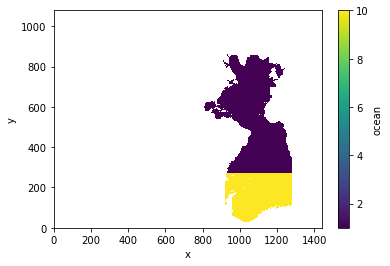

In [31]:
# Atlantic Ocean Mask

mask_a = ocean_mask3.where(ocean_mask3 == 1)
mask_a.name = 'ocean'
mask_b = ocean_mask3.where(ocean_mask3 == 10)
mask_b = mask_b.where((mask_b.lon<20) & (mask_b.lon>-70))
mask_b.name = 'ocean'
mask3 = xr.merge([mask_a, mask_b], compat="no_conflicts")

mask3 = func_regrid(mask3, ds_out)
mask3.ocean.plot()

In [32]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

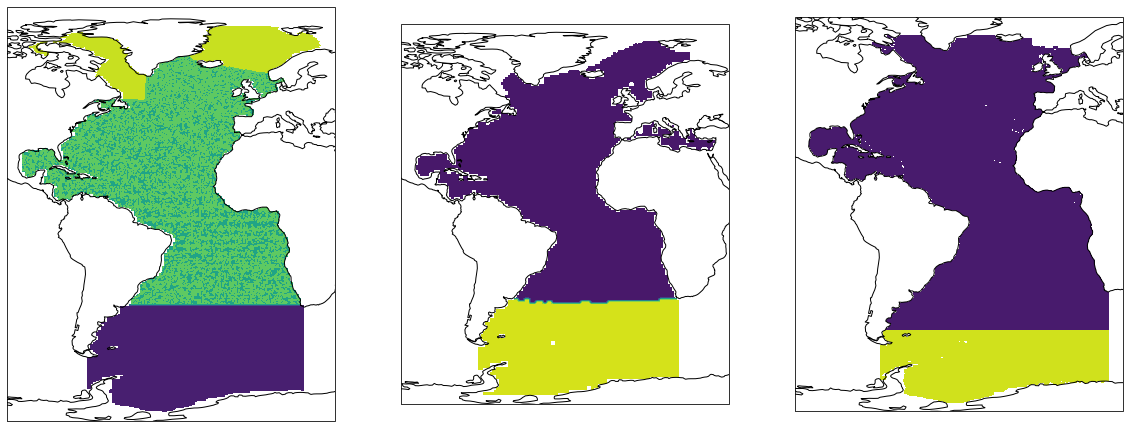

In [35]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())
ax.coastlines()
filled_c = ax.contourf(mask1.lon, mask1.lat, mask1, transform=ccrs.PlateCarree())

ax = fig.add_subplot(1, 3, 2, projection=ccrs.PlateCarree())
ax.coastlines()
filled_c = ax.contourf(mask2.lon, mask2.lat, mask2, transform=ccrs.PlateCarree())

ax = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
ax.coastlines()
filled_c = ax.contourf(mask3.lon, mask3.lat, mask3.ocean, transform=ccrs.PlateCarree())